In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/becoder_2021/
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/becoder_2021
'=0.24.0'				     catboost_info	    tmp
 automl_regression_powerplant_output.ipynb   original_data.csv
 becoder_2021_EVRAZ.ipynb		     original_data.gsheet


In [ ]:
!pip install dask distributed --upgrade
!pip install auto-sklearn
!pip install catboost
!pip install pytorch-tabnet

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn.apionly as sns

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso, SGDRegressor, LinearRegression, ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
import xgboost as xgb
import catboost
import lightgbm as lgb

from scipy import stats
import numpy as np

from sklearn.model_selection import KFold
from pytorch_tabnet.tab_model import TabNetRegressor
import torch
from sklearn.preprocessing import QuantileTransformer

from autosklearn.metrics import mean_absolute_error as auto_MSE
import autosklearn

from  autosklearn.regression import AutoSklearnRegressor


/usr/local/lib/python3.7/dist-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/pyparsing.py:3190: FutureWarning: Possible set intersection at position 3
  self.re = re.compile(self.reString)


# Общая статистика по датасету

- Самая популярная марка Э76ХФ
- Марка Э76ХФ встречается 4953 раза
- Всего пропусков 119806
- Пропусков для самой популярной марки 92965

### Пропуски для интересующих нас колонок

- 'химшлак последний Al2O3' 	= 1689 ~ 34.100545%
- 'химшлак последний CaO ' 	= 521 ~ 10.518877%
- 'химшлак последний R   ' 	= 521 ~ 10.518877%
- 'химшлак последний SiO2' 	= 1689 ~ 34.100545%

### Количество выбросов = 696 

# Топ моделей для определенной колонки
- 'химшлак последний Al2O3' => CatBoostRegressor MSE => 0.21864096794018217
- 'химшлак последний CaO' => TabNet MSE => 2.8724990535003587
- 'химшлак последний R' => TabNet MSE => 0.00614606972300847
- 'химшлак последний SiO2' => TabNet MSE => 0.15857949090211607

Сноска: в некоторых местах TabNet превосходит CatBoostRegressor скорее из-за разницы сидов чем превосходстве архитектур. Также я не пробовал обширное поле гиперпараметров которые предоставляют эти библиотеки, но чаще всего такие докрутки могут позволить выиграть не более чем 0.1 в метрике.

Также некоторые категориальные признаки были отброшены, поскольку я посчитал их совершенно бесполезными, но если на эти фичи посмотрит человек с доменными знаниями он сможет подсказать мне что из них может играть большую роль, а что просто зашумлять модель.

Ниже следует EDA анализ и проверка этих данных на разных моделях. От xgboost заканчивая AutoML.

# Look at data

In [4]:
dataset = pd.read_csv("original_data.csv", encoding='utf-8', sep=";")
null_values = dataset.isna().sum().sum()
dataset = dataset.drop(['Unnamed: 0', 'nplv', 'ПРОФИЛЬ', 'DT'], axis=1)
dataset

,МАРКА,t вып-обр,t обработка,t под током,t продувка,ПСН гр.,чист расход C,чист расход Cr,чист расход Mn,чист расход Si,чист расход V,температура первая,температура последняя,Ar (интенс.),N2 (интенс.),эл. энергия (интенс.),произв жидкая сталь,произв количество обработок,произв количество плавок,произв количество плавок (цел),расход газ Ar,расход газ N2,расход C пров.,сыпуч известь РП,сыпуч кварцит,сыпуч кокс пыль УСТК,сыпуч кокс. мелочь (сух.),сыпуч кокс. мелочь КМ1,сыпуч шпат плав.,ферспл CaC2,ферспл FeMo,ферспл FeSi-75,ферспл FeV азот.,ферспл FeV-80,ферспл Mn5Si65Al0.5,ферспл Ni H1 пласт.,ферспл SiMn18,ферспл ферванит,ферспл фх850А,эл. энергия,...,химсталь первый C_1,химсталь первый Cr_1,химсталь первый Cu_1,химсталь первый Mn_1,химсталь первый Mo_1,химсталь первый N_1,химсталь первый Ni_1,химсталь первый P_1,химсталь первый S_1,химсталь первый Si_1,химсталь первый Ti_1,химсталь первый V_1,химсталь последний Al,химсталь последний C,химсталь последний Ca,химсталь последний Cr,химсталь последний Cu,химсталь последний Mn,химсталь последний Mo,химсталь последний N,химсталь последний Ni,химсталь последний P,химсталь последний S,химсталь последний Si,химсталь последний Ti,химсталь последний V,химшлак первый Al2O3_1,химшлак первый CaO_1,химшлак первый FeO_1,химшлак первый MgO_1,химшлак первый MnO_1,химшлак первый R_1,химшлак первый SiO2_1,химшлак последний Al2O3,химшлак последний CaO,химшлак последний FeO,химшлак последний MgO,химшлак последний MnO,химшлак последний R,химшлак последний SiO2
0,Э76ХФ,"29,0","45,3666667","24,4","41,0333333",NaN,"0,45646","0,059572","0,117446","0,104762","0,0409383","1557,0","1580,0","13,6067425",NaN,"12809,0163934","115,5","1,0","1,0","1,0","18,611",NaN,NaN,NaN,NaN,"0,17",NaN,"0,401","0,123","0,02",NaN,NaN,NaN,"0,051939","0,112",NaN,"0,182",NaN,"0,106","5209,0",...,"0,389","0,368","0,127","0,682","0,01","0,011","0,086","0,009","0,023","0,459","0,002","0,002","0,003","0,756","0,0001","0,417","0,126","0,779","0,009","0,012","0,086","0,011","0,018","0,559","0,003","0,037",NaN,"63,7","1,1","3,7","0,12","2,6",NaN,NaN,"53,4","1,0","5,8","0,15","2,6",NaN
1,Э76ХФ,"26,0","44,0666667","13,8666667","44,0666667",NaN,"0,359285","0,083738","0,160923","0,110327","0,0400831","1601,0","1591,0","8,074721",NaN,"12816,3461538","111,6","1,0","1,0","1,0","11,659",NaN,NaN,NaN,NaN,"0,488",NaN,NaN,"0,094","0,02",NaN,NaN,NaN,"0,050854","0,102",NaN,"0,251",NaN,"0,149","2962,0",...,"0,465","0,345","0,112","0,643","0,009","0,011","0,08","0,007","0,023","0,461","0,002","0,002","0,003","0,774","0,0003","0,416","0,109","0,767","0,008","0,013","0,079","0,008","0,021","0,543","0,003","0,038",NaN,"58,5","0,8","4,9","0,14","2,2",NaN,NaN,"59,3","0,6","4,1","0,11","2,3",NaN
2,Э76ХФ,"24,0","43,35","17,95","43,35",NaN,"0,331665","0,08149","0,132332","0,13986","0,0416225","1593,0","1586,0","13,801968",NaN,"12511,4206128","115,8","1,0","1,0","1,0","19,871",NaN,NaN,NaN,NaN,"0,05",NaN,"0,346","0,061","0,02",NaN,NaN,NaN,"0,052807","0,16",NaN,"0,204",NaN,"0,145","3743,0",...,"0,513","0,351","0,107","0,674","0,007","0,011","0,078","0,008","0,019","0,455","0,002","0,002","0,004","0,77","0,0009","0,417","0,108","0,788","0,006","0,012","0,078","0,008","0,013","0,568","0,003","0,038",NaN,"58,0","0,8","8,6","0,12","2,6",NaN,NaN,"57,2","0,5","8,1","0,13","2,3",NaN
3,Э76ХФ,"17,0","46,1833333","19,8166667","46,1833333",NaN,"0,377945","0,133194","0,221605","0,165186","0,0420497","1589,0","1589,0","12,6649585",NaN,"12998,1497056","116,3","1,0","1,0","1,0","19,497",NaN,NaN,"0,077",NaN,"0,05",NaN,"0,39","0,059","0,02",NaN,NaN,NaN,"0,053349","0,161",NaN,"0,345",NaN,"0,237","4293,0",...,"0,487","0,31","0,105","0,611","0,009","0,011","0,07","0,006","0,02","0,434","0,001","0,001","0,003","0,767","0,0002","0,419","0,103","0,795","0,008","0,013","0,07","0,007","0,014","0,571","0,003","0,038",NaN,"59,8","0,4","6,4","0,11","2,4",NaN,NaN,"60,3","0,5","6,3","0,12","2,6",NaN
4,Э76ХФ,"20,0","48,5","17,0333333","48,5",NaN,"0,389875","0,105094","0,169459","0,143024","0,0409

In [5]:
null_values

119806

In [6]:
search_column = 'МАРКА'
most_popular_mark = dataset[search_column].value_counts(normalize=False, sort=True, ascending=False, bins=None, dropna=True).index[0]
most_popular_mark

'Э76ХФ'

In [7]:
missed_values_stat = dataset[dataset[search_column] == most_popular_mark].isna().sum()
dataset_mark = dataset[dataset[search_column] == most_popular_mark].drop([search_column], axis=1).fillna(0)
dataset_mark.head(3)

,t вып-обр,t обработка,t под током,t продувка,ПСН гр.,чист расход C,чист расход Cr,чист расход Mn,чист расход Si,чист расход V,температура первая,температура последняя,Ar (интенс.),N2 (интенс.),эл. энергия (интенс.),произв жидкая сталь,произв количество обработок,произв количество плавок,произв количество плавок (цел),расход газ Ar,расход газ N2,расход C пров.,сыпуч известь РП,сыпуч кварцит,сыпуч кокс пыль УСТК,сыпуч кокс. мелочь (сух.),сыпуч кокс. мелочь КМ1,сыпуч шпат плав.,ферспл CaC2,ферспл FeMo,ферспл FeSi-75,ферспл FeV азот.,ферспл FeV-80,ферспл Mn5Si65Al0.5,ферспл Ni H1 пласт.,ферспл SiMn18,ферспл ферванит,ферспл фх850А,эл. энергия,химсталь первый Al_1,химсталь первый C_1,химсталь первый Cr_1,химсталь первый Cu_1,химсталь первый Mn_1,химсталь первый Mo_1,химсталь первый N_1,химсталь первый Ni_1,химсталь первый P_1,химсталь первый S_1,химсталь первый Si_1,химсталь первый Ti_1,химсталь первый V_1,химсталь последний Al,химсталь последний C,химсталь последний Ca,химсталь последний Cr,химсталь последний Cu,химсталь последний Mn,химсталь последний Mo,химсталь последний N,химсталь последний Ni,химсталь последний P,химсталь последний S,химсталь последний Si,химсталь последний Ti,химсталь последний V,химшлак первый Al2O3_1,химшлак первый CaO_1,химшлак первый FeO_1,химшлак первый MgO_1,химшлак первый MnO_1,химшлак первый R_1,химшлак первый SiO2_1,химшлак последний Al2O3,химшлак последний CaO,химшлак последний FeO,химшлак последний MgO,химшлак последний MnO,химшлак последний R,химшлак последний SiO2
0,"29,0","45,3666667","24,4","41,0333333",0,"0,45646","0,059572","0,117446","0,104762","0,0409383","1557,0","1580,0","13,6067425",0,"12809,0163934","115,5","1,0","1,0","1,0","18,611",0,0,0,0,"0,17",0,"0,401","0,123","0,02",0,0,0,"0,051939","0,112",0,"0,182",0,"0,106","5209,0","0,002","0,389","0,368","0,127","0,682","0,01","0,011","0,086","0,009","0,023","0,459","0,002","0,002","0,003","0,756","0,0001","0,417","0,126","0,779","0,009","0,012","0,086","0,011","0,018","0,559","0,003","0,037",0,"63,7","1,1","3,7","0,12","2,6",0,0,"53,4","1,0","5,8","0,15","2,6",0
1,"26,0","44,0666667","13,8666667","44,0666667",0,"0,359285","0,083738","0,160923","0,110327","0,0400831","1601,0","1591,0","8,074721",0,"12816,3461538","111,6","1,0","1,0","1,0","11,659",0,0,0,0,"0,488",0,0,"0,094","0,02",0,0,0,"0,050854","0,102",0,"0,251",0,"0,149","2962,0","0,002","0,465","0,345","0,112","0,643","0,009","0,011","0,08","0,007","0,023","0,461","0,002","0,002","0,003","0,774","0,0003","0,416","0,109","0,767","0,008","0,013","0,079","0,008","0,021","0,543","0,003","0,038",0,"58,5","0,8","4,9","0,14","2,2",0,0,"59,3","0,6","4,1","0,11","2,3",0
2,"24,0","43,35","17,95","43,35",0,"0,331665","0,08149","0,132332","0,13986","0,0416225","1593,0","1586,0","13,801968",0,"12511,4206128","115,8","1,0","1,0","1,0","19,871",0,0,0,0,"0,05",0,"0,346","0,061","0,02",0,0,0,"0,052807","0,16",0,"0,204",0,"0,145","3743,0","0,002","0,513","0,351","0,107","0,674","0,007","0,011","0,078","0,008","0,019","0,455","0,002","0,002","0,004","0,77","0,0009","0,417","0,108","0,788","0,006","0,012","0,078","0,008","0,013","0,568","0,003","0,038",0,"58,0","0,8","8,6","0,12","2,6",0,0,"57,2","0,5","8,1","0,13","2,3",0


In [8]:
missed_values_mark = missed_values_stat.sum()

In [9]:
dataset_columns = list(dataset_mark.columns) 
dataset_mark = dataset_mark.astype(str)
for col in dataset_columns:
  dataset_mark[col] = dataset_mark[col].str.replace(",", ".").astype(float) 

In [10]:
dataset_mark.head()

,t вып-обр,t обработка,t под током,t продувка,ПСН гр.,чист расход C,чист расход Cr,чист расход Mn,чист расход Si,чист расход V,температура первая,температура последняя,Ar (интенс.),N2 (интенс.),эл. энергия (интенс.),произв жидкая сталь,произв количество обработок,произв количество плавок,произв количество плавок (цел),расход газ Ar,расход газ N2,расход C пров.,сыпуч известь РП,сыпуч кварцит,сыпуч кокс пыль УСТК,сыпуч кокс. мелочь (сух.),сыпуч кокс. мелочь КМ1,сыпуч шпат плав.,ферспл CaC2,ферспл FeMo,ферспл FeSi-75,ферспл FeV азот.,ферспл FeV-80,ферспл Mn5Si65Al0.5,ферспл Ni H1 пласт.,ферспл SiMn18,ферспл ферванит,ферспл фх850А,эл. энергия,химсталь первый Al_1,химсталь первый C_1,химсталь первый Cr_1,химсталь первый Cu_1,химсталь первый Mn_1,химсталь первый Mo_1,химсталь первый N_1,химсталь первый Ni_1,химсталь первый P_1,химсталь первый S_1,химсталь первый Si_1,химсталь первый Ti_1,химсталь первый V_1,химсталь последний Al,химсталь последний C,химсталь последний Ca,химсталь последний Cr,химсталь последний Cu,химсталь последний Mn,химсталь последний Mo,химсталь последний N,химсталь последний Ni,химсталь последний P,химсталь последний S,химсталь последний Si,химсталь последний Ti,химсталь последний V,химшлак первый Al2O3_1,химшлак первый CaO_1,химшлак первый FeO_1,химшлак первый MgO_1,химшлак первый MnO_1,химшлак первый R_1,химшлак первый SiO2_1,химшлак последний Al2O3,химшлак последний CaO,химшлак последний FeO,химшлак последний MgO,химшлак последний MnO,химшлак последний R,химшлак последний SiO2
0,29.0,45.366667,24.400000,41.033333,0.0,0.456460,0.059572,0.117446,0.104762,0.040938,1557.0,1580.0,13.606742,0.0,12809.016393,115.5,1.0,1.0,1.0,18.611,0.0,0.0,0.000,0.0,0.170,0.0,0.401,0.123,0.02,0.0,0.0,0.0,0.051939,0.112,0.0,0.182,0.0,0.106,5209.0,0.002,0.389,0.368,0.127,0.682,0.010,0.011,0.086,0.009,0.023,0.459,0.002,0.002,0.003,0.756,0.0001,0.417,0.126,0.779,0.009,0.012,0.086,0.011,0.018,0.559,0.003,0.037,0.0,63.7,1.1,3.7,0.12,2.6,0.0,0.0,53.4,1.0,5.8,0.15,2.6,0.0
1,26.0,44.066667,13.866667,44.066667,0.0,0.359285,0.083738,0.160923,0.110327,0.040083,1601.0,1591.0,8.074721,0.0,12816.346154,111.6,1.0,1.0,1.0,11.659,0.0,0.0,0.000,0.0,0.488,0.0,0.000,0.094,0.02,0.0,0.0,0.0,0.050854,0.102,0.0,0.251,0.0,0.149,2962.0,0.002,0.465,0.345,0.112,0.643,0.009,0.011,0.080,0.007,0.023,0.461,0.002,0.002,0.003,0.774,0.0003,0.416,0.109,0.767,0.008,0.013,0.079,0.008,0.021,0.543,0.003,0.038,0.0,58.5,0.8,4.9,0.14,2.2,0.0,0.0,59.3,0.6,4.1,0.11,2.3,0.0
2,24.0,43.350000,17.950000,43.350000,0.0,0.331665,0.081490,0.132332,0.139860,0.041622,1593.0,1586.0,13.801968,0.0,12511.420613,115.8,1.0,1.0,1.0,19.871,0.0,0.0,0.000,0.0,0.050,0.0,0.346,0.061,0.02,0.0,0.0,0.0,0.052807,0.160,0.0,0.204,0.0,0.145,3743.0,0.002,0.513,0.351,0.107,0.674,0.007,0.011,0.078,0.008,0.019,0.455,0.002,0.002,0.004,0.770,0.0009,0.417,0.108,0.788,0.006,0.012,0.078,0.008,0.013,0.568,0.003,0.038,0.0,58.0,0.8,8.6,0.12,2.6,0.0,0.0,57.2,0.5,8.1,0.13,2.3,0.0
3,17.0,46.183333,19.816667,46.183333,0.0,0.377945,0.133194,0.221605,0.165186,0.042050,1589.0,1589.0,12.664958,0.0,12998.149706,116.3,1.0,1.0,1.0,19.497,0.0,0.0,0.077,0.0,0.050,0.0,0.390,0.059,0.02,0.0,0.0,0.0,0.053349,0.161,0.0,0.345,0.0,0.237,4293.0,0.002,0.487,0.310,0.105,0.611,0.009,0.011,0.070,0.006,0.020,0.434,0.001,0.001,0.003,0.767,0.0002,0.419,0.103,0.795,0.008,0.013,0.070,0.007,0.014,0.571,0.003,0.038,0.0,59.8,0.4,6.4,0.11,2.4,0.0,0.0,60.3,0.5,6.3,0.12,2.6,0.0
4,20.0,48.500000,17.033333,48.500000,0.0,0.389875,0.105094,0.169459,0.143024,0.040967,1597.0,1592.0,10.298350,0.0,12987.475538,115.0,1.0,1.0,1.0,16.649,0.0,0.0,0.082,0.0,0.050,0.0,0.412,0.035,0.02,0.0,0.0,0.0,0.051975,0.149,0.0,0.263,0.0,0.187,3687.0,0.002,0.461,0.334,0.105,0.652,0.007,0.011,0.080,0.007,0.020,0.447,0.001,0.002,0.003,0.784,0.0003,0.421,0.105,0.796,0.006,0.013,0.081,0.008,0.017,0.568,0.003,0.037,0.0,59.6,0.7,4.7,0.12,2.4,0.0,0.0,60.3,0.6,4.5,0.09,2.5,0.0


In [11]:
target_col_1 = "химшлак последний Al2O3"
target_col_2 = "химшлак последний CaO"
target_col_3 = "химшлак последний R"
target_col_4 = "химшлак последний SiO2"

target_columns = [target_col_1, target_col_2, target_col_3, target_col_4]

def print_missed(column, missed_values_stat=missed_values_stat, total=len(dataset_mark)):
  missed_count = missed_values_stat[column]
  print(f"- '{column:22}' \t= {missed_count} ~ {missed_count/total*100:2f}%")

print_missed(target_col_1)
print_missed(target_col_2)
print_missed(target_col_3)
print_missed(target_col_4)


- 'химшлак последний Al2O3' 	= 1689 ~ 34.100545%
- 'химшлак последний CaO ' 	= 521 ~ 10.518877%
- 'химшлак последний R   ' 	= 521 ~ 10.518877%
- 'химшлак последний SiO2' 	= 1689 ~ 34.100545%


## Check general statistic

In [12]:
dataset_mark.describe()

,t вып-обр,t обработка,t под током,t продувка,ПСН гр.,чист расход C,чист расход Cr,чист расход Mn,чист расход Si,чист расход V,температура первая,температура последняя,Ar (интенс.),N2 (интенс.),эл. энергия (интенс.),произв жидкая сталь,произв количество обработок,произв количество плавок,произв количество плавок (цел),расход газ Ar,расход газ N2,расход C пров.,сыпуч известь РП,сыпуч кварцит,сыпуч кокс пыль УСТК,сыпуч кокс. мелочь (сух.),сыпуч кокс. мелочь КМ1,сыпуч шпат плав.,ферспл CaC2,ферспл FeMo,ферспл FeSi-75,ферспл FeV азот.,ферспл FeV-80,ферспл Mn5Si65Al0.5,ферспл Ni H1 пласт.,ферспл SiMn18,ферспл ферванит,ферспл фх850А,эл. энергия,химсталь первый Al_1,химсталь первый C_1,химсталь первый Cr_1,химсталь первый Cu_1,химсталь первый Mn_1,химсталь первый Mo_1,химсталь первый N_1,химсталь первый Ni_1,химсталь первый P_1,химсталь первый S_1,химсталь первый Si_1,химсталь первый Ti_1,химсталь первый V_1,химсталь последний Al,химсталь последний C,химсталь последний Ca,химсталь последний Cr,химсталь последний Cu,химсталь последний Mn,химсталь последний Mo,химсталь последний N,химсталь последний Ni,химсталь последний P,химсталь последний S,химсталь последний Si,химсталь последний Ti,химсталь последний V,химшлак первый Al2O3_1,химшлак первый CaO_1,химшлак первый FeO_1,химшлак первый MgO_1,химшлак первый MnO_1,химшлак первый R_1,химшлак первый SiO2_1,химшлак последний Al2O3,химшлак последний CaO,химшлак последний FeO,химшлак последний MgO,химшлак последний MnO,химшлак последний R,химшлак последний SiO2
count,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.0,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.0,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.0,4953.0,4953.0,4953.000000,4953.000000,4953.0,4953.000000,4953.0,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.00000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000
mean,23.082980,40.906989,18.548671,40.863322,2.160134,0.336085,0.111653,0.119613,0.122428,0.035380,1401.548960,1419.284070,10.151394,0.0,11607.604643,102.435090,0.902483,0.894811,0.894811,15.208024,0.0,0.002122,0.086346,0.000020,0.056448,0.000545,0.337963,0.045033,0.017450,0.0,0.0,0.0,0.044563,0.138360,0.0,0.184226,0.0,0.197419,4021.837068,0.001631,0.423539,0.280172,0.091703,0.600276,0.006419,0.008927,0.063620,0.008121,0.017928,0.401760,0.001574,0.002619,0.002802,0.685971,0.000277,0.373486,0.091371,0.705142,0.005810,0.010344,0.063777,0.008899,0.013374,0.505457,0.002695,0.033123,2.693600,48.799091,0.603352,10.334464,0.17784,2.155118,14.994488,2.987200,50.558147,0.522996,8.072057,0.107462,2.111775,15.840400
std,15.807013,16.955769,7.713087,16.745060,1.469840,0.136584,0.046652,0.062093,0.056130,0.012456,483.100736,488.927937,4.769499,0.0,4082.567179,35.197922,0.324641,0.306827,0.306827,7.452135,0.0,0.007557,0.087324,0.000635,0.068680,0.015116,0.153735,0.029347,0.006887,0.0,0.0,0.0,0.015675,0.067915,0.0,0.096490,0.0,0.082582,1717.532424,0.000705,0.155344,0.098450,0.033615,0.209691,0.002843,0.003362,0.023744,0.003373,0.006931,0.140717,0.000749,0.002851,0.001085,0.235515,0.000259,0.128117,0.033456,0.241881,0.002688,0.003833,0.023738,0.003600,0.005261,0.173572,0.001020,0.011442,2.058938,17.388830,0.613921,4.849815,0.20357,0.797653,10.959092,2.285001,17.696516,0.269405,4.083288,0.066169,0.754323,11.532217
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0

In [13]:
empty_columns = dataset_mark.describe().iloc[1][(dataset_mark.describe().iloc[1][:] == 0)].index.tolist()

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [14]:
dataset_mark.describe()[target_columns]

,химшлак последний Al2O3,химшлак последний CaO,химшлак последний R,химшлак последний SiO2
count,4953.000000,4953.000000,4953.000000,4953.000000
mean,2.987200,50.558147,2.111775,15.840400
std,2.285001,17.696516,0.754323,11.532217
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,52.800000,2.100000,0.000000
50%,3.900000,56.400000,2.300000,22.300000
75%,4.700000,58.700000,2.500000,25.400000
max,14.200000,67.500000,3.100000,28.600000


In [15]:
dataset_mark.describe()[empty_columns]

,N2 (интенс.),расход газ N2,ферспл FeMo,ферспл FeSi-75,ферспл FeV азот.,ферспл Ni H1 пласт.,ферспл ферванит
count,4953.0,4953.0,4953.0,4953.0,4953.0,4953.0,4953.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
dataset_mark = dataset_mark.drop(empty_columns, axis=1)

## Data Correlation

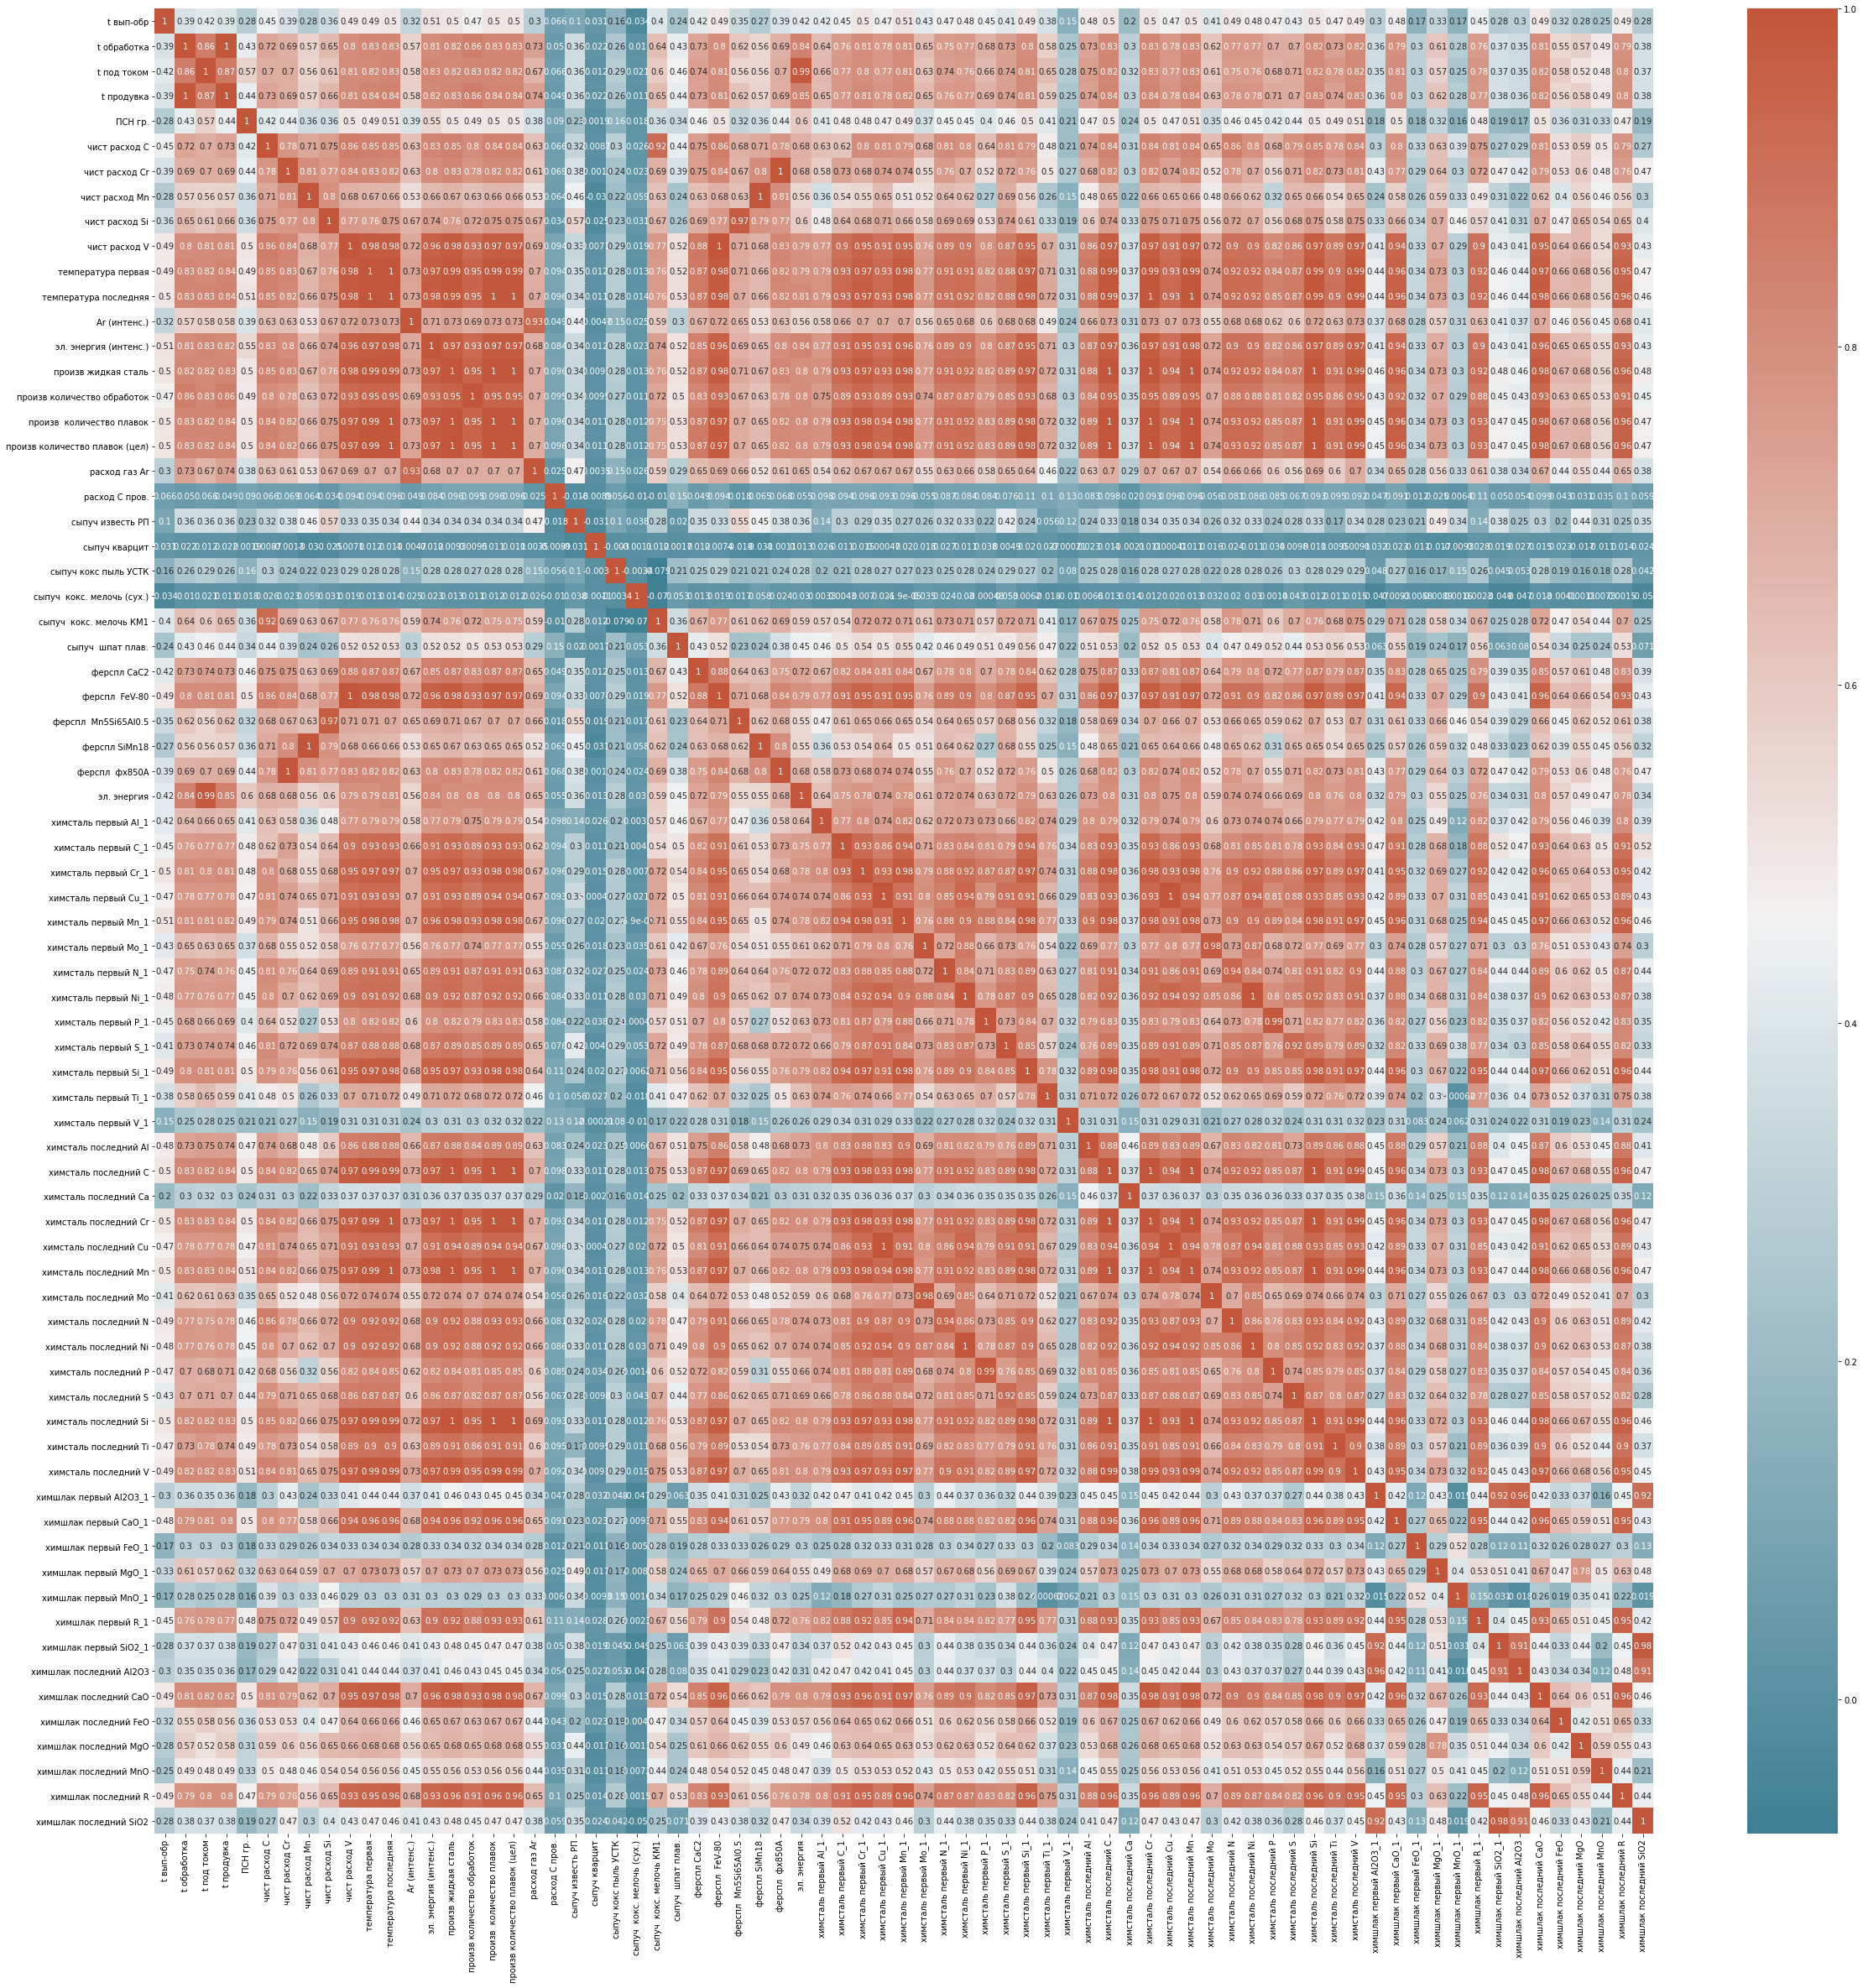

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(40,40))
corr = dataset_mark.corr()# plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True), ax=ax)

## Detect otliers

In [17]:
z = np.abs(stats.zscore(dataset_mark))
threshold = 3
dataset_mark_cleaned = dataset_mark[(z < threshold).all(axis=1)]
outliers_amount =  len(dataset_mark) - len(dataset_mark_cleaned)
print(f"Delete examples => {outliers_amount} ~ {outliers_amount / len(dataset_mark_cleaned):3f}%")

Delete examples => 696 ~ 0.163495%


## Variance

In [18]:
pd.DataFrame(dataset_mark_cleaned.var().values, index=dataset_mark_cleaned.var().index).T

,t вып-обр,t обработка,t под током,t продувка,ПСН гр.,чист расход C,чист расход Cr,чист расход Mn,чист расход Si,чист расход V,температура первая,температура последняя,Ar (интенс.),эл. энергия (интенс.),произв жидкая сталь,произв количество обработок,произв количество плавок,произв количество плавок (цел),расход газ Ar,расход C пров.,сыпуч известь РП,сыпуч кварцит,сыпуч кокс пыль УСТК,сыпуч кокс. мелочь (сух.),сыпуч кокс. мелочь КМ1,сыпуч шпат плав.,ферспл CaC2,ферспл FeV-80,ферспл Mn5Si65Al0.5,ферспл SiMn18,ферспл фх850А,эл. энергия,химсталь первый Al_1,химсталь первый C_1,химсталь первый Cr_1,химсталь первый Cu_1,химсталь первый Mn_1,химсталь первый Mo_1,химсталь первый N_1,химсталь первый Ni_1,химсталь первый P_1,химсталь первый S_1,химсталь первый Si_1,химсталь первый Ti_1,химсталь первый V_1,химсталь последний Al,химсталь последний C,химсталь последний Ca,химсталь последний Cr,химсталь последний Cu,химсталь последний Mn,химсталь последний Mo,химсталь последний N,химсталь последний Ni,химсталь последний P,химсталь последний S,химсталь последний Si,химсталь последний Ti,химсталь последний V,химшлак первый Al2O3_1,химшлак первый CaO_1,химшлак первый FeO_1,химшлак первый MgO_1,химшлак первый MnO_1,химшлак первый R_1,химшлак первый SiO2_1,химшлак последний Al2O3,химшлак последний CaO,химшлак последний FeO,химшлак последний MgO,химшлак последний MnO,химшлак последний R,химшлак последний SiO2
0,248.769532,236.396254,58.589242,234.907384,2.21564,0.019737,0.002304,0.003811,0.002988,0.000174,265753.620566,272125.999069,22.539779,1.868225e+07,1413.457562,0.107433,0.107433,0.107433,50.23901,0.000015,0.005795,0.0,0.00056,0.0,0.023056,0.000779,0.00005,0.000276,0.004238,0.009198,0.007217,2.902515e+06,5.288185e-07,0.026975,0.010981,0.001259,0.05003,0.000008,0.000013,0.000618,0.000012,0.000051,0.022458,5.735030e-07,0.000001,0.000001,0.063267,3.344760e-08,0.018731,0.001247,0.066751,0.000007,0.000016,0.000618,0.000014,0.00003,0.034424,0.000001,0.000148,4.181692,342.460995,0.145174,23.355653,0.015612,0.708243,120.284906,5.191103,356.33954,0.075465,16.721032,0.003226,0.645745,133.413893


# Let's make some predictions :)

In [29]:
class Experiment:
  def __init__(self, 
           dataset = None,
           target_column = None,
           cross_validation = True,
           folds_amount = 10,
           model = xgb.XGBRegressor(
                objective ='reg:squarederror', 
                max_depth = 5, 
              )
           ):
    self.dataset = dataset
    self.target_column = target_column
    # model
    self.model = model

    # transform data
    self.data_transformer = StandardScaler()

    # cross validation
    self.cross_validation = cross_validation,
    self.dataset_features = self.dataset.drop([self.target_column], axis=1)
    self.dataset_targets = self.dataset[self.target_column]
    self.folds_amount = folds_amount

  def experiment(self):
    print(f"Experiment for '{self.target_column}' column")

    model_name = str(self.model.__class__).split('.')[-1].replace("'>", "")
    self.model = make_pipeline(self.data_transformer, self.model)
    train_result = cross_validate(self.model, self.dataset_features, self.dataset_targets, cv=self.folds_amount, 
              scoring={'MSE': make_scorer(mean_squared_error)}, n_jobs=-1)
    
    MSE = train_result['test_MSE'].mean()
    print(f'Mean MSE => {MSE}')
    
  def try_models(self, models=[
                               LinearRegression(), 
                               DecisionTreeRegressor(max_depth=5),
                               Ridge(alpha=1.0),
                               SGDRegressor(max_iter=1000, tol=1e-3),
                               xgb.XGBRegressor(),
                               catboost.CatBoostRegressor()
                        ]):
    for model in models:
      model_name = str(model.__class__).split('.')[-1].replace("'>", "")
      model = make_pipeline(self.data_transformer, model)

      train_result = cross_validate(model, self.dataset_features, self.dataset_targets, cv=self.folds_amount, 
               scoring={'MSE': make_scorer(mean_squared_error)}, n_jobs=-1)
      
      MSE = train_result['test_MSE'].mean()
      print(f'Mean {model_name} MSE => {MSE}')




In [22]:
exp_1 = Experiment(
    dataset=dataset_mark_cleaned,
    target_column=target_col_1
)
exp_2 = Experiment(
    dataset=dataset_mark_cleaned,
    target_column=target_col_2,
)
exp_3 = Experiment(
    dataset=dataset_mark_cleaned,
    target_column=target_col_3
)
exp_4 = Experiment(
    dataset=dataset_mark_cleaned,
    target_column=target_col_4
)
exp_1.experiment()
exp_2.experiment()
exp_3.experiment()
exp_4.experiment()

Experiment for 'химшлак последний Al2O3' column
Mean MSE => 0.22175046526240133
Experiment for 'химшлак последний CaO' column
Mean MSE => 3.320770730756049
Experiment for 'химшлак последний R' column
Mean MSE => 0.007310092203124695
Experiment for 'химшлак последний SiO2' column
Mean MSE => 0.16486272478436353


## Experiments results for XGBRegressor
- Experiment for 'химшлак последний Al2O3' column
  - Mean MSE => 0.22175046526240133
- Experiment for 'химшлак последний CaO' column
  - Mean MSE => 3.320770730756049
- Experiment for 'химшлак последний R' column
  - Mean MSE => 0.007310092203124695
- Experiment for 'химшлак последний SiO2' column
  - Mean MSE => 0.16486272478436353

In [23]:
exp_1 = Experiment(
    dataset=dataset_mark_cleaned,
    target_column=target_col_1,
    model=catboost.CatBoostRegressor()
)
exp_2 = Experiment(
    dataset=dataset_mark_cleaned,
    target_column=target_col_2,
    model=catboost.CatBoostRegressor()
)
exp_3 = Experiment(
    dataset=dataset_mark_cleaned,
    target_column=target_col_3,
    model=catboost.CatBoostRegressor()
)
exp_4 = Experiment(
    dataset=dataset_mark_cleaned,
    target_column=target_col_4,
    model=catboost.CatBoostRegressor()
)
exp_1.experiment()
exp_2.experiment()
exp_3.experiment()
exp_4.experiment()

Experiment for 'химшлак последний Al2O3' column
Mean MSE => 0.21864096794018217
Experiment for 'химшлак последний CaO' column
Mean MSE => 3.1059214512332174
Experiment for 'химшлак последний R' column
Mean MSE => 0.0066393922960442334
Experiment for 'химшлак последний SiO2' column
Mean MSE => 0.20915911537569745


## Experiments results for CatBoostRegressor
- Experiment for 'химшлак последний Al2O3' column
  - Mean MSE => 0.21864096794018217
- Experiment for 'химшлак последний CaO' column
  - Mean MSE => 3.1059214512332174
- Experiment for 'химшлак последний R' column
  - Mean MSE => 0.0066393922960442334
- Experiment for 'химшлак последний SiO2' column
  - Mean MSE => 0.20915911537569745

In [24]:
hyper_params = {
    # 'task': 'train',
    # 'boosting_type': 'gbdt',
    # 'objective': 'regression',
    # 'metric': ['l2', 'mse'],
    # 'learning_rate': 0.005,
    # 'feature_fraction': 0.9,
    # 'bagging_fraction': 0.7,
    # 'bagging_freq': 10,
    # 'verbose': 0,
    # "max_depth": 8,
    # "num_leaves": 128,  
    # "max_bin": 512,
    # "num_iterations": 1000,
    # "n_estimators": 1000
}

exp_1 = Experiment(
    dataset=dataset_mark_cleaned,
    target_column=target_col_1,
    model=lgb.LGBMRegressor(**hyper_params)
)
exp_2 = Experiment(
    dataset=dataset_mark_cleaned,
    target_column=target_col_2,
    model=lgb.LGBMRegressor(**hyper_params)
)
exp_3 = Experiment(
    dataset=dataset_mark_cleaned,
    target_column=target_col_3,
    model=lgb.LGBMRegressor(**hyper_params)
)
exp_4 = Experiment(
    dataset=dataset_mark_cleaned,
    target_column=target_col_4,
    model=lgb.LGBMRegressor(**hyper_params)
)
exp_1.experiment()
exp_2.experiment()
exp_3.experiment()
exp_4.experiment()

Experiment for 'химшлак последний Al2O3' column
Mean MSE => 0.23041988269811203
Experiment for 'химшлак последний CaO' column
Mean MSE => 3.1534914666581475
Experiment for 'химшлак последний R' column
Mean MSE => 0.00670356352834865
Experiment for 'химшлак последний SiO2' column
Mean MSE => 0.16417526958753897


- Experiment for 'химшлак последний Al2O3' column
  - Mean MSE => 0.23041988269811203
- Experiment for 'химшлак последний CaO' column
  - Mean MSE => 3.1534914666581475
- Experiment for 'химшлак последний R' column
  - Mean MSE => 0.00670356352834865
- Experiment for 'химшлак последний SiO2' column
  - Mean MSE => 0.16417526958753897

# Try some deep learning

In [25]:
class TabNetExperiment:
  def __init__(self, 
           dataset = None,
           target_column = None,
           cross_validation = True,
           folds_amount = 10,
           model = TabNetRegressor(verbose=0, seed=42),
           ):
    self.dataset = dataset
    self.target_column = target_column
    # model
    self.model = model
    self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # transform data
    self.data_transformer = StandardScaler()
    self.seed = 42

    # cross validation
    self.cross_validation = cross_validation,
    self.dataset_features = self.dataset.drop([self.target_column], axis=1).to_numpy()
    self.dataset_targets = self.dataset[self.target_column].to_numpy().reshape(-1, 1)
    self.folds_amount = folds_amount
    self.k_fold = KFold(n_splits=self.folds_amount, random_state=self.seed, shuffle=True)

  def experiment(self, epochs=2000, patience=200):
    print(f"Experiment for '{self.target_column}' column")

    CV_score_array = []
    model = None
    
    for train_index, test_index in self.k_fold.split(self.dataset_features):
      
      X_train, X_valid = self.dataset_features[train_index], self.dataset_features[test_index]
      y_train, y_valid = self.dataset_targets[train_index], self.dataset_targets[test_index]

      x_scaler = StandardScaler()
      X_train = x_scaler.fit_transform(X_train)
      X_valid = x_scaler.transform(X_valid)
      
      model = TabNetRegressor(verbose=20, 
                              seed=self.seed,
                              device_name=self.device
                              )
      model.fit(X_train=X_train, 
                      y_train=y_train,
                      eval_set=[(X_valid, y_valid)],
                      patience=patience, max_epochs=epochs,
                      eval_metric=['mse'])
      CV_score_array.append(model.best_cost)
    
    MSE = np.mean(CV_score_array, axis=0)
    self.model = model
    print(f'Mean TabNet MSE => {MSE}')

In [56]:
tab_1 = TabNetExperiment(
    dataset=dataset_mark_cleaned,
    target_column=target_col_1,
)
tab_1.experiment()

Experiment for 'химшлак последний Al2O3' column
Device used : cuda
epoch 0  | loss: 13.66576| val_0_mse: 9.88748 |  0:00:00s
epoch 20 | loss: 0.30277 | val_0_mse: 0.88274 |  0:00:03s
epoch 40 | loss: 0.2302  | val_0_mse: 2.19323 |  0:00:06s
epoch 60 | loss: 0.19264 | val_0_mse: 0.27261 |  0:00:10s
epoch 80 | loss: 0.16366 | val_0_mse: 0.21863 |  0:00:13s
epoch 100| loss: 0.13957 | val_0_mse: 0.21482 |  0:00:17s
epoch 120| loss: 0.1381  | val_0_mse: 0.22998 |  0:00:20s
epoch 140| loss: 0.13538 | val_0_mse: 0.22319 |  0:00:23s
epoch 160| loss: 0.11735 | val_0_mse: 0.2125  |  0:00:27s
epoch 180| loss: 0.10618 | val_0_mse: 0.21072 |  0:00:30s
epoch 200| loss: 0.11186 | val_0_mse: 0.22839 |  0:00:33s
epoch 220| loss: 0.09375 | val_0_mse: 0.24281 |  0:00:37s
epoch 240| loss: 0.08607 | val_0_mse: 0.23854 |  0:00:40s
epoch 260| loss: 0.08849 | val_0_mse: 0.2137  |  0:00:43s

Early stopping occurred at epoch 274 with best_epoch = 74 and best_val_0_mse = 0.19858
Best weights from best epoch are 

In [26]:
tab_3 = TabNetExperiment(
    dataset=dataset_mark_cleaned,
    target_column=target_col_3,
)
tab_3.experiment()

Experiment for 'химшлак последний R' column
Device used : cuda
epoch 0  | loss: 5.25388 | val_0_mse: 3.03819 |  0:00:00s
epoch 20 | loss: 0.03164 | val_0_mse: 0.26209 |  0:00:03s
epoch 40 | loss: 0.02501 | val_0_mse: 0.02988 |  0:00:07s
epoch 60 | loss: 0.0208  | val_0_mse: 0.02028 |  0:00:11s
epoch 80 | loss: 0.01858 | val_0_mse: 0.01839 |  0:00:15s
epoch 100| loss: 0.01699 | val_0_mse: 0.01641 |  0:00:18s
epoch 120| loss: 0.01476 | val_0_mse: 0.01526 |  0:00:22s
epoch 140| loss: 0.01111 | val_0_mse: 0.01133 |  0:00:25s
epoch 160| loss: 0.00932 | val_0_mse: 0.00926 |  0:00:29s
epoch 180| loss: 0.00839 | val_0_mse: 0.00853 |  0:00:33s
epoch 200| loss: 0.00738 | val_0_mse: 0.0083  |  0:00:37s
epoch 220| loss: 0.00717 | val_0_mse: 0.27842 |  0:00:40s
epoch 240| loss: 0.00599 | val_0_mse: 0.0074  |  0:00:44s
epoch 260| loss: 0.00605 | val_0_mse: 0.00703 |  0:00:48s
epoch 280| loss: 0.00563 | val_0_mse: 0.00681 |  0:00:51s
epoch 300| loss: 0.00621 | val_0_mse: 0.00704 |  0:00:55s
epoch 320

In [55]:
tab_2 = TabNetExperiment(
    dataset=dataset_mark_cleaned,
    target_column=target_col_2,
)
tab_2.experiment()

Experiment for 'химшлак последний CaO' column
Device used : cuda
epoch 0  | loss: 2796.10965| val_0_mse: 2814.73149|  0:00:00s
epoch 20 | loss: 15.51979| val_0_mse: 22.73168|  0:00:04s
epoch 40 | loss: 9.80097 | val_0_mse: 174.45834|  0:00:07s
epoch 60 | loss: 7.70995 | val_0_mse: 7.82553 |  0:00:11s
epoch 80 | loss: 3.88547 | val_0_mse: 4.63696 |  0:00:14s
epoch 100| loss: 3.6113  | val_0_mse: 3.59755 |  0:00:18s
epoch 120| loss: 3.22942 | val_0_mse: 3.30532 |  0:00:21s
epoch 140| loss: 3.18732 | val_0_mse: 3.2508  |  0:00:25s
epoch 160| loss: 2.84011 | val_0_mse: 3.2906  |  0:00:29s
epoch 180| loss: 2.80409 | val_0_mse: 3.07076 |  0:00:32s
epoch 200| loss: 2.53022 | val_0_mse: 3.04198 |  0:00:36s
epoch 220| loss: 2.55326 | val_0_mse: 3.21534 |  0:00:39s
epoch 240| loss: 2.2875  | val_0_mse: 3.2236  |  0:00:43s
epoch 260| loss: 2.17353 | val_0_mse: 3.66004 |  0:00:46s
epoch 280| loss: 1.91161 | val_0_mse: 4.2626  |  0:00:50s
epoch 300| loss: 1.87466 | val_0_mse: 3.6472  |  0:00:53s
ep

In [57]:
tab_4 = TabNetExperiment(
    dataset=dataset_mark_cleaned,
    target_column=target_col_4,
)
tab_4.experiment()

Experiment for 'химшлак последний SiO2' column
Device used : cuda
epoch 0  | loss: 373.23228| val_0_mse: 365.13635|  0:00:00s
epoch 20 | loss: 1.54364 | val_0_mse: 1.29942 |  0:00:03s
epoch 40 | loss: 0.61889 | val_0_mse: 0.25282 |  0:00:07s
epoch 60 | loss: 0.2764  | val_0_mse: 0.18913 |  0:00:10s
epoch 80 | loss: 0.30538 | val_0_mse: 0.28697 |  0:00:14s
epoch 100| loss: 0.1705  | val_0_mse: 0.12551 |  0:00:17s
epoch 120| loss: 0.41459 | val_0_mse: 0.30286 |  0:00:21s
epoch 140| loss: 0.23562 | val_0_mse: 0.30821 |  0:00:24s
epoch 160| loss: 0.17888 | val_0_mse: 0.15802 |  0:00:28s
epoch 180| loss: 0.17118 | val_0_mse: 0.14325 |  0:00:31s
epoch 200| loss: 0.14124 | val_0_mse: 0.18155 |  0:00:34s
epoch 220| loss: 0.22962 | val_0_mse: 0.10822 |  0:00:38s
epoch 240| loss: 0.14852 | val_0_mse: 0.10215 |  0:00:41s
epoch 260| loss: 0.23093 | val_0_mse: 0.35846 |  0:00:45s
epoch 280| loss: 0.13613 | val_0_mse: 0.14218 |  0:00:48s
epoch 300| loss: 0.20099 | val_0_mse: 0.15192 |  0:00:52s
epoc

## Experiments results for TabNet
- Experiment for 'химшлак последний Al2O3' column
  - Mean TabNet MSE => 0.2335877841742052
- Experiment for 'химшлак последний CaO' column
 - Mean TabNet MSE => 2.8724990535003587
- Experiment for 'химшлак последний SiO2' column
  - Mean TabNet MSE => 0.15857949090211607

# And AutoML sklearn показывает себя хуже, но работает :)

In [21]:
class AutoMLExperiment:
  def __init__(self, 
           dataset = None,
           target_column = None,
           cross_validation = True,
           folds_amount = 10,
           ):
    self.seed = 42
    self.dataset = dataset
    self.target_column = target_column
    # model
    self.model = None
    self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # transform data
    self.data_transformer = StandardScaler()

    # cross validation
    self.cross_validation = cross_validation,
    self.dataset_features = self.dataset.drop([self.target_column], axis=1).to_numpy()
    self.dataset_targets = self.dataset[self.target_column].to_numpy()
    self.folds_amount = folds_amount
    self.k_fold = KFold(n_splits=self.folds_amount, random_state=self.seed, shuffle=True)
    self.iter = 5

  def experiment(self):
    print(f"Experiment for '{self.target_column}' column")
    CV_score_array = []
    model = None
    
    for train_index, test_index in self.k_fold.split(self.dataset_features):
      
      X_train, X_valid = self.dataset_features[train_index], self.dataset_features[test_index]
      y_train, y_valid = self.dataset_targets[train_index], self.dataset_targets[test_index]
      
      model = AutoSklearnRegressor(
                  time_left_for_this_task=120,
                  per_run_time_limit=30,
                  tmp_folder=f'./tmp/folder_tmp/{self.iter}/',
                  output_folder=f'./tmp/folder_out{self.iter}/',
                  disable_evaluator_output=False,
                  seed=self.seed,
                  n_jobs=-1,
                  metric=autosklearn.metrics.make_scorer('MSE', auto_MSE)
            )
      
      model.fit(X_train, y_train)
      predictions = model.predict(X_valid)
      MSE = mean_squared_error(y_valid, predictions)
      CV_score_array.append(MSE)
      print(MSE)
      self.iter += 1
    
    MSE = np.mean(CV_score_array, axis=0)
    self.model = model
    print(f'Mean AutoML MSE => {MSE}')



In [20]:
automl_1 = AutoMLExperiment(
    dataset=dataset_mark_cleaned,
    target_column=target_col_1
)
automl_1.experiment()

Experiment for 'химшлак последний Al2O3' column
0.18526244249801263
0.16951620675636125
0.275250385552932
0.22842154953415808
0.24557945982089407
0.23661454073403637
0.1957956207212535
0.27003120735934405
0.19583409118735423
0.19809099560996715


NameError: ignored

In [22]:
automl_2 = AutoMLExperiment(
    dataset=dataset_mark_cleaned,
    target_column=target_col_2
)
automl_2.experiment()

Experiment for 'химшлак последний CaO' column
3.5190331556754697
3.551000435631266


KeyboardInterrupt: ignored